
## The Data


ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

### Visualizing the Data

-------
Let's take a closer look at the data.

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [7]:
my_data_dir = 'C:\\Users\\Dilee\\tensor flow 2\\FINAL_TF2_FILES\\TF_2_Notebooks_and_Data\\04-CNNs\\cell_images'

In [8]:
os.listdir(my_data_dir) 

['test', 'train']

In [9]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [10]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [11]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [12]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [13]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [14]:
para_img= imread(para_cell)

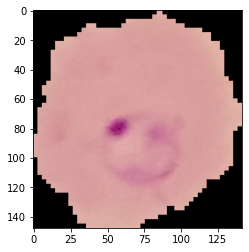

In [15]:
plt.imshow(para_img)

In [16]:
para_img.shape

(148, 142, 3)

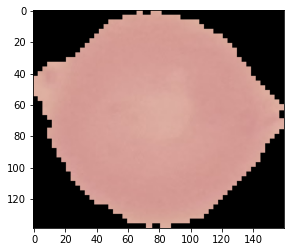

In [17]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

**Let's check how many images there are.**

In [18]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [19]:
len(os.listdir(train_path+'\\uninfected'))

12480

**Let's find out the average dimensions of these images.**

In [20]:
unifected_cell.shape

(139, 160, 3)

In [21]:
para_img.shape

(148, 142, 3)

In [22]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

C:\Users\Dilee\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


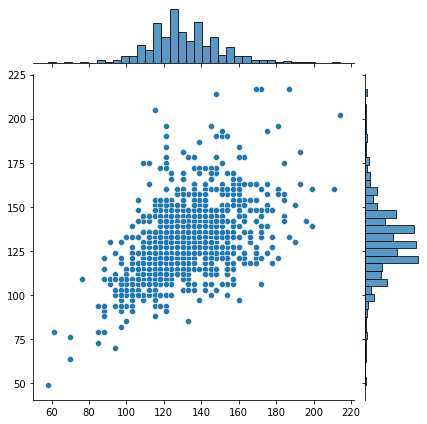

In [23]:
sns.jointplot(dim1,dim2)

In [24]:
np.mean(dim1)

130.92538461538462

In [25]:
np.mean(dim2)

130.75

In [26]:
image_shape = (130,130,3)

## Preparing the Data for the model

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

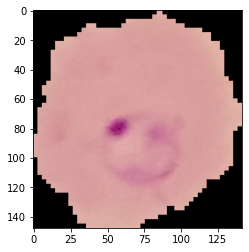

In [30]:
plt.imshow(para_img)

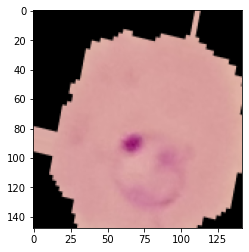

In [31]:
plt.imshow(image_gen.random_transform(para_img))

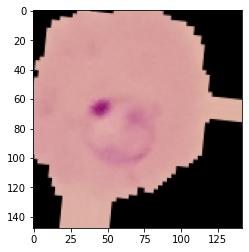

In [32]:
plt.imshow(image_gen.random_transform(para_img))

In [33]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [34]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Creating the Model

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [36]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Early Stopping

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [41]:
batch_size = 16

In [42]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [43]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [44]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
#results = model.fit_generator(train_image_gen,epochs=20,
                       #       validation_data=test_image_gen,
                        #     callbacks=[early_stop])

In [47]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

# Evaluating the Model

In [49]:
model.metrics_names

['loss', 'accuracy']

In [53]:
model.evaluate(test_image_gen)

163/163 [==============================] - 12s 74ms/step - loss: 0.6950 - accuracy: 0.5000


[0.6949538588523865, 0.5]

In [51]:
from tensorflow.keras.preprocessing import image

In [54]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 12s 75ms/step


In [55]:
pred_probabilities

array([[0.538172  ],
       [0.5410168 ],
       [0.53482777],
       ...,
       [0.5373278 ],
       [0.5428536 ],
       [0.5449696 ]], dtype=float32)

In [56]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
predictions = pred_probabilities > 0.5

In [58]:
# Numpy can treat this as True/False for us
predictions

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [59]:
from sklearn.metrics import classification_report,confusion_matrix

In [60]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1300
           1       0.50      1.00      0.67      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



In [61]:
confusion_matrix(test_image_gen.classes,predictions)

array([[   0, 1300],
       [   0, 1300]], dtype=int64)

# Predicting on an Image

In [62]:
# Your file path will be different!
para_cell

'C:\\Users\\Dilee\\tensor flow 2\\FINAL_TF2_FILES\\TF_2_Notebooks_and_Data\\04-CNNs\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [63]:
my_image = image.load_img(para_cell,target_size=image_shape)

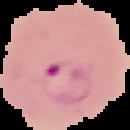

In [64]:
my_image

In [65]:
type(my_image)

PIL.Image.Image

In [66]:
my_image = image.img_to_array(my_image)

In [67]:
type(my_image)

numpy.ndarray

In [68]:
my_image.shape

(130, 130, 3)

In [69]:
my_image = np.expand_dims(my_image, axis=0)

In [70]:
my_image.shape

(1, 130, 130, 3)

In [71]:
model.predict(my_image)

1/1 [==============================] - 0s 78ms/step


array([[1.]], dtype=float32)

In [72]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [73]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}